# Проект "А/В-тесты"

_для локальной работы_

https://drive.google.com/file/d/1Hskt8ns_2uaWjBHujSDsn5aLBKrchWBk/view?usp=sharing

https://drive.google.com/file/d/1pmp-AjnUMO2yfdbnxTXzSGPOgVGo3ZpM/view?usp=sharing

https://drive.google.com/file/d/1WwPmms3mOMzIUM8DLTAtxysyW9G4nNRi/view?usp=sharing

## Введение

Наш интернет-магазин приготовил список гипотез для для увеличения выручки. Нам предоставили файл с гипотезами и два файла с данными о покупках и визитах, разбитые на группы А и В.

Задачи исследования — приоритизировать гипотезы, проанализировать результат А/В-теста.

## Импорт библиотек

In [25]:
# импортируем библиотеки numpy, pandas и модуль scipy.stats библиотеки scipy
import numpy as np
import pandas as pd
import scipy.stats as stats

# импортируем библиотеку datetime для работы с датами
import datetime as dt
from datetime import datetime, date
from datetime import timedelta

# Задаем некоторые опции библиотеки pandas, которые
# настраивают вывод
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 12)
pd.set_option('display.width', 80)

# импортируем matplotlib для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных и знакомство с ними

In [26]:
# для локальной работы

! gdown --id 1Hskt8ns_2uaWjBHujSDsn5aLBKrchWBk
! gdown --id 1pmp-AjnUMO2yfdbnxTXzSGPOgVGo3ZpM
! gdown --id 1WwPmms3mOMzIUM8DLTAtxysyW9G4nNRi

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Hskt8ns_2uaWjBHujSDsn5aLBKrchWBk
To: /content/visitors.csv
100% 1.14k/1.14k [00:00<00:00, 2.78MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pmp-AjnUMO2yfdbnxTXzSGPOgVGo3ZpM
To: /content/orders.csv
100% 48.5k/48.5k [00:00<00:00, 73.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: htt

In [27]:
# для локальной работы

try:
  hypothesis = pd.read_csv('/content/hypothesis.csv')
  orders = pd.read_csv('/content/orders.csv')
  visitors = pd.read_csv('/content/visitors.csv')

# для работы в среде ЯП

except:
  hypothesis = pd.read_csv('/datasets/hypothesis.csv')
  orders = pd.read_csv('/datasets/orders.csv')
  visitors = pd.read_csv('/datasets/visitors.csv')

In [28]:
# смотрим  на файл hypothesis

hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [29]:
# смотрим  на файл orders

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [30]:
# для удобства дальнейшей работы переименуем столбцы датафрейма orders, 
# названия столбцов пропишем = названиям столбцов в рабочих формулах

orders.columns = ['orderId', 'userId', 'date', 'revenue', 'group']

In [31]:
# смотрим  на файл visitors

visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Подготовка данных к работе

### Изменение регистра столбцов

In [32]:
# названия столбцов в hypothesis к нижнему регистру

hypothesis.columns = hypothesis.columns.str.lower()

### Поиск пропущенных значений

In [33]:
hypothesis.isna().mean()

hypothesis    0.0
reach         0.0
impact        0.0
confidence    0.0
efforts       0.0
dtype: float64

In [34]:
orders.isna().mean()

orderId    0.0
userId     0.0
date       0.0
revenue    0.0
group      0.0
dtype: float64

In [35]:
visitors.isna().mean()

date        0.0
group       0.0
visitors    0.0
dtype: float64

### Поиск явных дубликатов

In [36]:
hypothesis.duplicated().sum()

0

In [37]:
orders.duplicated().sum()

0

In [38]:
visitors.duplicated().sum()

0

### Вывод по подготовке данных

Данные чистые, без дубликатов и пропусков. Работаем дальше.

## Приоритизация гипотез

Посмотрим на файл с гипотезами полностью

In [39]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [40]:
print(f'Всего {len(hypothesis)} гипотез')

Всего 9 гипотез


Задача выбрать потенциально самые прибыльные гипотезы

### ICE

Вспомним, как считается ICE:

ICE = (Impact x Confidence)/ Efforts 

In [41]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence']\
                  / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


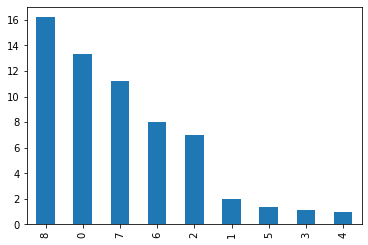

In [42]:
hypothesis['ICE'].sort_values(ascending=False).plot(kind='bar');

In [43]:
# посмотрим топ-4 гипотезы по ICE

top_4_ICE = hypothesis[['hypothesis', 'ICE']]\
           .sort_values(by='ICE', ascending=False).index[:4]
top_4_ICE

Int64Index([8, 0, 7, 6], dtype='int64')

### Вывод по ICE

По методу _ICE_ наиболее интересны гипотезы [8, 0, 7, 6].

### RICE

RICE отличается от ICE добавлением еще одного компонента — охват (англ. reach). Формула для расчета RICE:

RICE = (Reach x Impact x Confidence)/ Efforts 

In [44]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact']\
                   * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


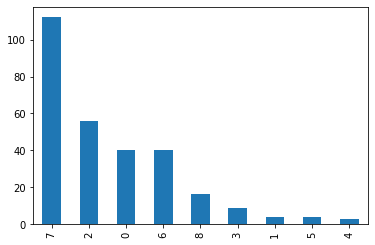

In [45]:
hypothesis['RICE'].sort_values(ascending=False).plot(kind='bar');

In [46]:
# топ-4 гипотезы по RICE

top_4_RICE = hypothesis[['hypothesis', 'RICE']]\
           .sort_values(by='RICE', ascending=False).index[:4]
top_4_RICE

Int64Index([7, 2, 0, 6], dtype='int64')

### Вывод по RICE

По методу _RICE_ наиболее интересны гипотезы [7, 2, 0, 6].

### Вывод по приоритизации гипотез по _ICE_ и _RICE_

Список потенциально прибыльных гипоз по _RICE_ поменялся из-за введения параметра _Reach_. Лидер по методу _ICE_, гипотеза №8, не попала в Топ-4 по методу _RICE_.RICE более информативен, учитывает охват пользователей, ориентируемся на него. 

Три из четырех топовых гипотез по _ICE_ попадает в список топовых гипотез по _RICE_, обе метрики приоритизируют гипотезы на 75% одинаково. Наш финальный список выглядит так:

**[7, 2, 0, 6]**

Пятая гипотеза по методу _RICE_ выглядит в 2,5 раза менее интересной, ее и следующие за ней гипотезы считаем не интересными для бизнеса.



## Анализ A/B-теста

### График кумулятивной выручки по группам. Сделайте выводы и предположения

In [47]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.\
           apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], \
           orders['group'] == x['group'])].\
           agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', \
'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.\
apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
                                        visitors['group'] == x['group'])]\
      .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
      .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated\
.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

         date group  orders  buyers  revenue  visitors
0  2019-08-01     A      24      20   148579       719
1  2019-08-01     B      21      20   101217       713
2  2019-08-02     A      44      38   242401      1338
3  2019-08-02     B      45      43   266748      1294
4  2019-08-03     A      68      62   354874      1845


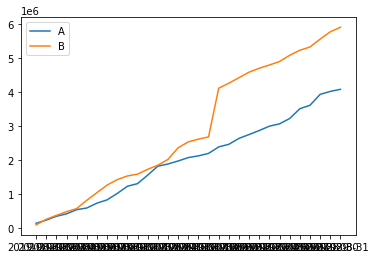

In [48]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.legend();

Выручка равномерно увеличивается на протяжении всего теста. Выручка по группе В делает резкий скачок, по группе А тоже есть несколько точек роста. Это либо появление очень дорогих заказов, либо резкое увеличение количества заказов

### График кумулятивного среднего чека по группам

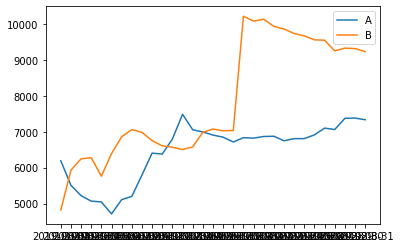

In [49]:
# Построим графики среднего чека по группам — 
# разделим кумулятивную выручку на кумулятивное число заказов:

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']\
         /cumulativeRevenueA['orders'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']\
         /cumulativeRevenueB['orders'], label='B');
plt.legend();

### Вывод по кумулятивному среднему чеку

Средний чек группы А делает несколько резких скачков в начале теста и нормализуется с середины теста. Возможно, были крупные заказы в стартовом периоде теста.

Для группы В размер среднего чека носит неравномерный характер на протяжении всего теста. Несколько взлетов и падений на старте. Резкий скачок в середине теста и падение к концу.

### График относительного изменения кумулятивного среднего чека группы B к группе A

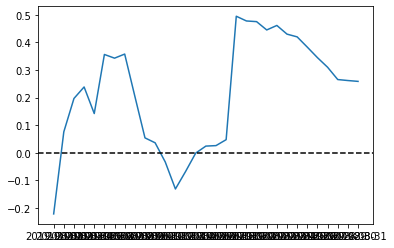

In [50]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, \
              left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']\
                                          /mergedCumulativeRevenue['ordersB'])\
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

В нескольких местах график делает скачки — в эти моменты различие между средними чеками групп А и В резко меняется. Возможно, в данных есть выбросы, отвечающие за резкие скачки среднего чек.

### Вывод по графику относительного изменения кумулятивного среднего чека

По такому "скачущему" графику тяжело сделать какие-то выводы, кроме того, что в данных, скорее всего, есть аномалии.

### График кумулятивной конверсии

(0.0, 30.0, 0.0, 0.04)

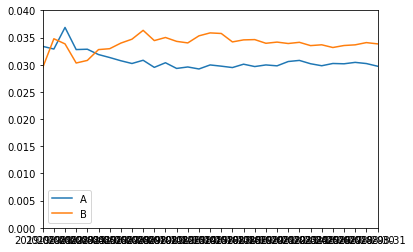

In [51]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0, 0.04])

Конверсия по обеим группа колебалась в первой половине теста, начиная с середины конверсия для А и В выровнялась. Конверсия для В к концу теста стабильно выше таковой для А на 0.005

### Вывод по графику кумулятивной конверсии

Куумулятивная конверсия группы В практически с самого начала теста выше таковой по группе А.

### График относительного изменения кумулятивной конверсии группы B к группе A

(0.0, 30.0, -0.15, 0.25)

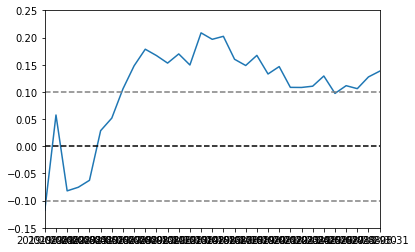

In [52]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date',\
       how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")
#plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.15, 0.25])

В начале теста кумулятивная конверсия В "проваливается", но затем быстро выходит в плюс. Положительное значение прироста конверсии гр. В к таковой для гр. А остается до конца теста.

### Вывод по графику относительного изменения кумулятивной конверсии

Коверсия гр. В практически с самого начала теста больше таковой для группы А на минимум 10%.

### Точечный график количества заказов по пользователям

In [53]:
ordersByUsers = orders.groupby('userId', as_index=False).\
                  agg({'orderId':'nunique'})
ordersByUsers.columns = ['userId', 'orders']   
ordersByUsers.sort_values(by='orders', ascending=False).head()              

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


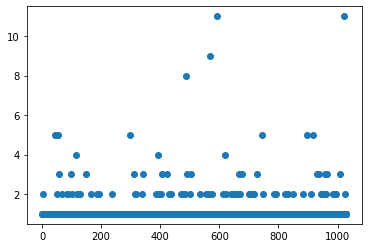

In [54]:
# построим точечный график распределения заказов по пользователям

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']);

In [55]:
# всего пользователей

print(f'всего {len(ordersByUsers)} пользователей')

всего 1031 пользователей


In [56]:
# сколько пользователей делают 1 заказ

ordersByUsers.query('orders == 1').count()

userId    937
orders    937
dtype: int64

In [57]:
# сколько пользователей делают 2 заказа

ordersByUsers.query('orders == 2').count()

userId    64
orders    64
dtype: int64

In [58]:
# полльзователи делают один или два заказа. Посчитаем, сколько пользователей 
# превышают это количество

ordersByUsers.query('orders > 2').count()

userId    30
orders    30
dtype: int64

In [59]:
# доля пользователей с 3 и более заказами

len(ordersByUsers.query('orders > 2')) / len(ordersByUsers)

0.029097963142580018

### Вывод по заказам на пользователя

В основном пользователи делают 1 заказ (90%), значительно меньше 2 заказа (6%). 3% пользователей совершают 3 и более заказов — некоторые делают по 9-11 заказов.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя

In [60]:
# посчитаем выборочные перцентили количества заказов на одного пользователя

print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% оформляли более 2 заказов, данные подтверждают наши выводы по графику. Примем 2 за границу количества заказов. Остальных пользователей с **бОльшим** количеством заказов уберем в дальнейшем как аномалии.

### Точечный график стоимостей заказов

In [61]:
# отсортируем датафрейм по полю revenue, посмотрим максимальные значения 
# в столбце

orders.sort_values(by='revenue', ascending=False).head()

,orderId,userId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


Был заказ на 1,3 млн, это определенно аномалия. Для сравнения посмотрим на медиану и среднее

In [62]:
orders['revenue'].agg(['median', 'mean'])

median    2978.000000
mean      8348.005848
Name: revenue, dtype: float64

Из-за аномально больших значений медиана в 2,5 раза меньше среднего. Построим элементарную гистограмму по этому полю, оценим распределение по сумма заказов

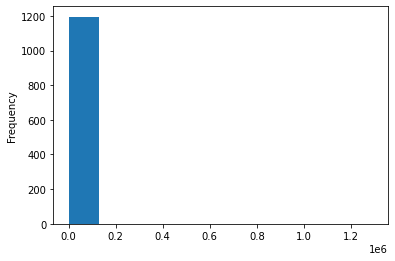

In [63]:
orders['revenue'].plot(kind='hist')

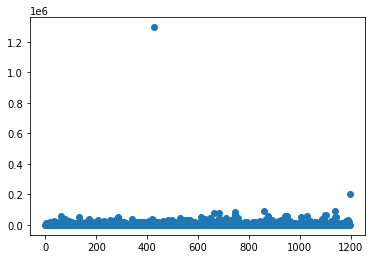

In [65]:
# не очень информативно, поэтому построим точечную диаграмму

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

На скаттере хорошо видно "великана" в 1,3кк. Заказы в основном меньше 100.000

### 95-й и 99-й перцентили стоимости заказов

Посмотрим на 90, 95 и 99 перцентили

In [67]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

По перцентилям видно — всего 5% заказов стоили дороже 28.000. Таких заказов 60 штук.

In [68]:
# посмотрим на 97.5 перцентиль

np.percentile(orders['revenue'], [90, 95, 97.5])

array([18168., 28000., 39530.])

2,5% заказов дороже 39.530, таких заказов 30 штук. Их мы в дальнейшем и будем считать аномальными.

_Делать срез по 95 перцентилю считаю слишком большой потерей данных. Заказы на скаттере лежат плотно, убираем лишь аномально большие 30 заказов, с остальным работаем._

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть. 

Уровень статистической значимости зададим 0.05

Подготовим данные.

In [69]:
visitors['date'] = visitors['date'].map(
                   lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  ...  ordersCummulativeB  \
0           101217                  24  ...                  21   
1           165531                  44  ...                  45   
2           114248                  68  ...                  61   
3           108571                  84  ...                  78   
4            92428                 109  ...                 101   

   revenueCummulativeB  visitorsPerDateA  visitorsPerDateB  \
0               101217               719               713   
1               266748               619               581   
2               3809

Посчитаем статистическую значимость различия в конверсии между группами. Создадим переменные _ordersByUsersA_ и _ordersByUsersB_ со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

In [70]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные _sampleA_ и *sampleB*, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [71]:
sampleA = pd.concat([ordersByUsersA['orders'],\
          pd.Series(0, index=np.arange(data['visitorsPerDateA']\
          .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],\
          pd.Series(0, index=np.arange(data['visitorsPerDateB']\
          .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [72]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.008


P-value меньше уровня значимости 0.05. Отвергаем нулевую гипотезу и считаем, что между конверсиям по группам А и В есть статистически значимая разница.

Выведем относительный прирост конверсии группы B = конверсия группы B / (конверсия группы A - 1)

In [73]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.138


Прирост конверсия по группе В составил 13.8%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию _mannwhitneyu()_ данные о выручке с заказов.

In [47]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']\
                  ['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.365


P-value больше уровня значимости, нулевую гипотезу не отвергаем, статистически значимой разницы между средними чеками нет

Посмотрим на относительное изменение по среднему чеку

In [48]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue']\
                      .mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.259


Средний чек группы В на 25% больше чека группы А

### Вывод по статистической значимости в "сырых" данных

При работе с "сырыми" данными между конверсиями тестируемых групп А и В есть статистически значимая разница. Между средними чеками такой разницы нет.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Примем за аномальных пользователей с количеством заказов больше 2 и совершивших заказы дороже 39.530. Мы потеряем 5% пользователей с количеством заказов больше 2 и пользователей, сделавших заказы на суммы, большие 39.530. Аномальных пользователей объеденим в переменную 
_abnormalUsers_.

Выведем первые строки этой переменной и черех аргумент [0] метода .shape() посмотрим, сколько таких пользователей. 



In [49]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 39530]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: userId, dtype: int64
46


In [50]:
print(f'всего удалим {abnormalUsers.shape[0] / len(ordersByUsers):} пользователей')

всего удалим 0.0446168768186227 пользователей


Потери менее 5% пользователей, приемлимо

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [51]:
 sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам. Сразу посчитаем относительное изменение конверсии.

In [52]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.003
0.188


In [53]:
# сравним с неочищенными данными

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.008
0.138


P-value стал еще меньше, еще дальше от уровня статистической значимости, нулевую гипотезу так же уверенно отвергаем. После фильтрации можем уверенно говорить, что между конверсие по группе А и группе В есть статистически значимая разница.

Фильтрация аномалий уменьшила относительную прирост конверсии в группе В к группе А. Тем не менее, конверсия в гр. В больше на ощутимые 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Результаты по конверсии практически не изменились, проверим средний чек

In [54]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.464
0.068


In [55]:
# вспомним "сырые" данные

print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']\
                  ['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue']\
                      .mean()/orders[orders['group']=='A']['revenue'].mean()-1))


0.365
0.259


Значение P-value принципиально не изменилось, оно все еще больше уровня статистической значимости. По очищенным данным нулевую гипотезу не отвергаем, статистически значимой разницы между средним чеком гр. А и гр. В нет.

По очищенным данным относительное изменение среднего чего гр. В к среднему чеку гр. А составляет положительные 6.8%.

### Вывод по статистически значимой разнице по конверсии и среднему чеку в очищенных данных

Результат принципиально не отличается от такового в "сырых" данных. Поменялось количественное значение P-value в меньшую сторону для конверсии, т.е. гипотезу о равенстве конверсий отвергаем.

P-value для среднего чека больше для очищенных данных, нулевую гипотезу о равенстве также принимаем.

## Решение по результатам теста и объясните его

После анализа результатов А/В-тестов имеем следующие факты:

1. Между конверсией гр. А и гр. В есть статистически значимая разница по "сырым" и очищенным данным
2. Конверсия группы В стабильно лучше таковой в группе А
3. Средний чек в начале теста был лучше в гр. В. Средний чек к середине теста стал больше в гр. А. К концу теста средний чек был на 30% больше в гр. В. Главное — положительная динамика среднего чека в пользу гр. В с середины теста
4. На графике кумулятивной конверсии гр. В стабильно лучше гр. А. На графике относительного изменения кумулятивной конверсии значение стабильно находится в плюсовом значении.

**На основании этих данных можно принять решение:
Признать тест успешным. Зафиксирована победа группы В.**

## Общий вывод

Нам попались чистые, хорошие данные. Потребовались минимальные корректировки в них, смена регистров в столбцах. Никаких пропусков, никаких дубликатов.

Единственное, с чем столкнулись — аномально большое количество заказов у некоторых пользователей и аномально большие суммы заказов. Таких пользователей мы исключили в отфильтрованных данных. Потери составили менее 5% данных.

Провели приоритезацию гипотез методами ICE и RICE. Данные по обоим методам почти совпали, предпочтение отдали выборке по методу RICE из-за учета охвата в этой метрике. Список потенциально прибыльных гипотез:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Провели анализ А/В-тестирования. Обнаружили, что:
1. Между конверсией гр. А и гр. В есть статистически значимая разница по "сырым" и очищенным данным
2. Конверсия группы В стабильно лучше таковой в группе А
3. Средний чек в начале теста был лучше в гр. В. Средний чек к середине теста стал больше в гр. А. К концу теста средний чек был на 30% больше в гр. В. Главное — положительная динамика среднего чека в пользу гр. В с середины теста
4. На графике кумулятивной конверсии гр. В стабильно лучше гр. А. На графике относительного изменения кумулятивной конверсии значение стабильно находится в плюсовом значении.

**По итогам этих выводов признаем тест успешным и определяем победителем группу В**.